In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error


import lightgbm as lgbm


/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
sys.path.append('../../')
import src.utils as utils

In [3]:
EXP_NUM = 5

In [4]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [5]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
playerTwitterFollowers = pd.read_csv(TRAIN_DIR / 'playerTwitterFollowers_train.csv')


In [6]:
games = pd.read_csv(TRAIN_DIR / 'games_train.csv')
games.homeAbbrev

0       ARI
1       DET
2       PHI
3       BOS
4       MIN
       ... 
7855     TB
7856    MIN
7857    CIN
7858    TOR
7859    PIT
Name: homeAbbrev, Length: 7860, dtype: object

In [18]:
transactions_train = pd.read_csv(TRAIN_DIR / 'transactions_train.csv')
transactions_train

,transactionId,playerId,playerName,date,fromTeamId,fromTeamName,toTeamId,toTeamName,effectiveDate,resolutionDate,typeCode,typeDesc,description,index
0,340732,547348.0,C.C. Lee,20180101,NaN,NaN,119,Los Angeles Dodgers,2018-01-01,2018-01-01,SFA,Signed as Free Agent,Los Angeles Dodgers signed free agent RHP C.C....,0
1,339458,621173.0,Dylan Baker,20180102,158.0,Milwaukee Brewers,119,Los Angeles Dodgers,2018-03-20,NaN,TR,Trade,Milwaukee Brewers traded RHP Dylan Baker to Lo...,1
2,357292,678876.0,Angel Rojas,20180102,NaN,NaN,147,New York Yankees,2018-01-02,2018-01-02,SFA,Signed as Free Agent,New York Yankees signed free agent SS Angel Ro...,1
3,341123,607054.0,Jace Peterson,20180102,NaN,NaN,147,New York Yankees,2018-01-02,2018-01-02,SFA,Signed as Free Agent,New York Yankees signed free agent 2B Jace Pet...,1
4,339458,NaN,NaN,20180102,119.0,Los Angeles Dodgers,158,Milwaukee Brewers,2018-01-02,NaN,TR,Trade,Milwaukee Brewers traded RHP Dylan Baker to Lo...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41025,480741,545343.0,Louis Head,20210429,139.0,Tampa Bay Rays,3292,Rays Alternate Training Site,2021-04-29,NaN,OPT,Optioned,Tampa Bay Rays optioned RHP Louis Head to Rays...,1214
41026,481071,656541.0,Sam Hilliard,20210429,115.0,Colorado Rockies,3298,Rockies Alternate Training Site,2021-04-29,NaN,OPT,Optioned,Colorado Rockies optioned RF Sam Hilliard to R...,1214
41027,481091,667670.0,Brent Rooker,20210429,142.0,Minnesota Twins,3304,Twins Alternate Training Site,2021-04-29,NaN,OPT,Optioned,Minnesota Twins optioned OF Brent Rooker to Tw...,1214
41028,481092,680777.0,Ryan Jeffers,20210429,142.0,Minnesota Twins,3304,Twins Alternate Training Site,2021-04-29,NaN,OPT,Optioned,Minnesota Twins optioned C Ryan Jeffers to Twi...,1214


In [8]:
scores = scores.merge(games.drop('date', axis=1), on=['gamePk'], how='left')


In [9]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
playerTwitterFollowers_cols = ['playerId', 'numberOfFollowers', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date',
        'homeWins', 'homeLosses', 'homeWinPct', 'homeScore',
        'awayWins', 'awayLosses', 'awayWinPct', 'awayScore']

feature_cols1 = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        'homeWins', 'homeLosses', 'homeWinPct', 'homeScore',
        'awayWins', 'awayLosses', 'awayWinPct', 'awayScore', 'numberOfFollowers']

feature_cols2 = ['label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

feature_cols3 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
        'homeWins', 'homeLosses', 'homeWinPct', 'homeScore',
       'assists', 'putOuts', 'errors', 'chances']

feature_cols4 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        'homeWins', 'homeLosses', 'homeWinPct', 'homeScore',
        'awayWins', 'awayLosses', 'awayWinPct', 'awayScore', 'numberOfFollowers']

In [10]:
players

,playerId,playerName,DOB,mlbDebutDate,birthCity,birthStateProvince,birthCountry,heightInches,weight,primaryPositionCode,primaryPositionName,playerForTestSetAndFuturePreds
0,665482,Gilberto Celestino,1999-02-13,2021-06-02,Santo Domingo,NaN,Dominican Republic,72,170,8,Outfielder,False
1,593590,Webster Rivas,1990-08-08,2021-05-28,Nagua,NaN,Dominican Republic,73,219,3,First Base,True
2,661269,Vladimir Gutierrez,1995-09-18,2021-05-28,Havana,NaN,Cuba,73,190,1,Pitcher,True
3,669212,Eli Morgan,1996-05-13,2021-05-28,Rancho Palos Verdes,CA,USA,70,190,1,Pitcher,True
4,666201,Alek Manoah,1998-01-09,2021-05-27,Homestead,FL,USA,78,260,1,Pitcher,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2056,672695,Geraldo Perdomo,1999-10-22,NaN,Santo Domingo,NaN,Dominican Republic,74,203,6,Shortstop,True
2057,672911,Jesus Cruz,1995-04-15,NaN,Salinas de Hidalgo,San Luis Potosi,Mexico,73,230,1,Pitcher,False
2058,676103,Damon Jones,1994-09-30,NaN,Twin Falls,ID,USA,77,233,1,Pitcher,True
2059,676755,Isaac Mattson,1995-07-14,NaN,Erie,PA,USA,74,205,1,Pitcher,True


In [11]:
players['DOY'] = pd.to_datetime(players['DOB'], format="%Y-%m-%d").dt.year
players['mlbDebutYear'] = pd.to_datetime(players['mlbDebutDate'], format="%Y-%m-%d").dt.year
players['DebutAge'] = players['mlbDebutYear'] - players['DOY']

In [12]:
# creat dataset
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')
train = train.merge(playerTwitterFollowers[playerTwitterFollowers_cols], on=['playerId', 'date'], how='left')

# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
birthCityn2num = {c: i for i, c in enumerate(train['birthCity'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_birthCity'] = train['birthCity'].map(birthCityn2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)

In [13]:
date_ = pd.to_datetime(train['date'], format="%Y%m%d")
train['annual_day'] = (date_ - pd.to_datetime(date_.dt.year, format="%Y")) /  timedelta(days=1)
train['week_day'] = date_.dt.weekday
train['month'] = date_.dt.month

In [14]:
# del players, rosters, scores, playerTwitterFollowers, targets
# gc.collect()

In [15]:
# train_X = train
train_y = train[['target1', 'target2', 'target3', 'target4']]

_index = (train['date'].astype(int) < 20210401)
x_train = train.loc[_index].reset_index(drop=True)
y_train = train_y.loc[_index].reset_index(drop=True)
x_valid = train.loc[~_index].reset_index(drop=True)
y_valid = train_y.loc[~_index].reset_index(drop=True)

In [16]:
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    oof_pred = np.clip(oof_pred, 0, 100)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score


# training lightgbm
params = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 100000,
 'learning_rate': 0.1,
 'random_state': 42,
}

oof1, model1, score1 = fit_lgbm(
    x_train[feature_cols1], y_train['target1'],
    x_valid[feature_cols1], y_valid['target1'],
    params
)
oof2, model2, score2 = fit_lgbm(
    x_train[feature_cols2], y_train['target2'],
    x_valid[feature_cols2], y_valid['target2'],
    params
)
oof3, model3, score3 = fit_lgbm(
    x_train[feature_cols3], y_train['target3'],
    x_valid[feature_cols3], y_valid['target3'],
    params
)
oof4, model4, score4 = fit_lgbm(
    x_train[feature_cols4], y_train['target4'],
    x_valid[feature_cols4], y_valid['target4'],
    params
)

score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.734967
Early stopping, best iteration is:
[82]	valid_0's l1: 0.734967
mae: 0.7349672398596401
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.51358
Early stopping, best iteration is:
[52]	valid_0's l1: 1.50888
mae: 1.5088752748049559
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.56478
[200]	valid_0's l1: 0.56478
[300]	valid_0's l1: 0.56478
[400]	valid_0's l1: 0.56478
Early stopping, best iteration is:
[309]	valid_0's l1: 0.56478
mae: 0.5647799006514344
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.30114
[200]	valid_0's l1: 1.25885
[300]	valid_0's l1: 1.23651
[400]	valid_0's l1: 1.21643
[500]	valid_0's l1: 1.20976
[600]	valid_0's l1: 1.20178
[700]	valid_0's l1: 1.19694
[800]	valid_0's l1: 1.19446
[900]	valid_0's l1: 1.19003
[1000]	valid_0's l1: 1.18635
[1100]	valid_0's l1: 1.18162
[1200]	valid_

In [22]:
score: 0.9954547214078484


In [18]:
oof_df = pd.DataFrame()
oof_df['date_playerId'] = train['date'][~_index].reset_index(drop=True).astype(str) + '_' + x_valid['label_playerId'].values.astype(str)
oof_df['target1'] = oof1
oof_df['target2'] = oof2
oof_df['target3'] = oof3
oof_df['target4'] = oof4
oof_df

,date_playerId,target1,target2,target3,target4
0,20210401_1845,3.698825e-01,4.759752,0.068535,3.718533
1,20210401_1770,2.667244e-07,0.338417,0.003014,0.056697
2,20210401_1663,3.163481e-03,0.453094,0.027736,5.538493
3,20210401_1756,1.498864e-01,2.836181,0.029848,1.571067
4,20210401_1704,6.711933e-04,0.600762,0.157057,0.287165
...,...,...,...,...,...
61835,20210430_159,2.619108e-07,0.206954,0.000760,0.442415
61836,20210430_555,2.619108e-07,0.066384,0.000055,0.084634
61837,20210430_437,2.619108e-07,0.290824,0.000784,0.209339
61838,20210430_1611,2.061042e-03,0.258017,0.003363,0.417385


In [19]:
oof_df.to_csv(OUTPUT_DIR / f'oof{EXP_NUM}.csv', index=False)

In [20]:
models = [model1, model2, model3, model4]
with open(OUTPUT_DIR / f"models{EXP_NUM}.pickle", mode="wb") as f:
    pickle.dump(models, f)

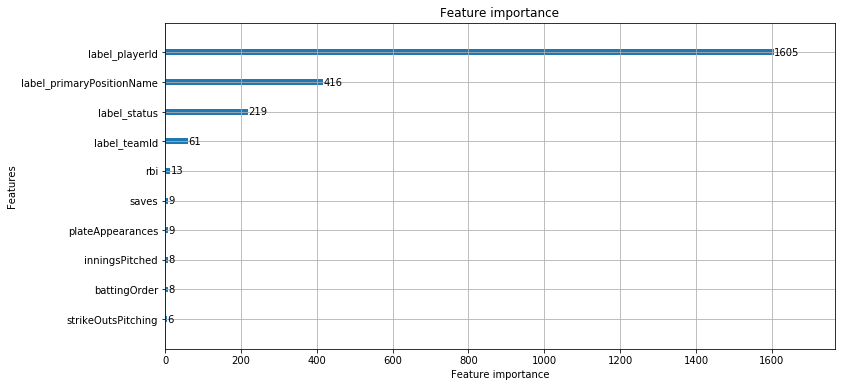

In [21]:
lgbm.plot_importance(model1, figsize=(12, 6), max_num_features=10)

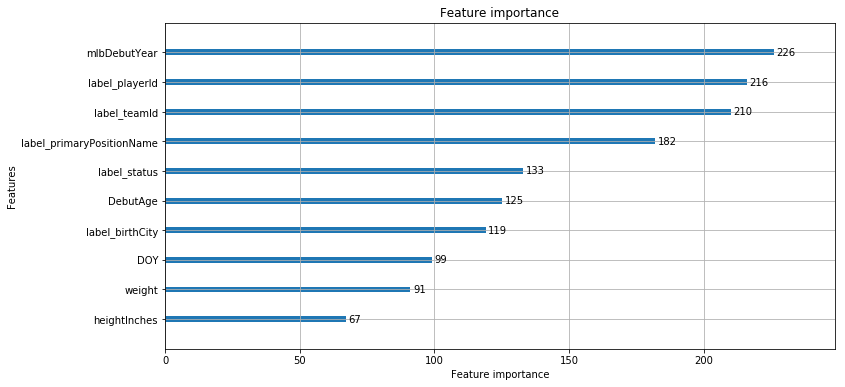

In [22]:
lgbm.plot_importance(model2, figsize=(12, 6), max_num_features=10)

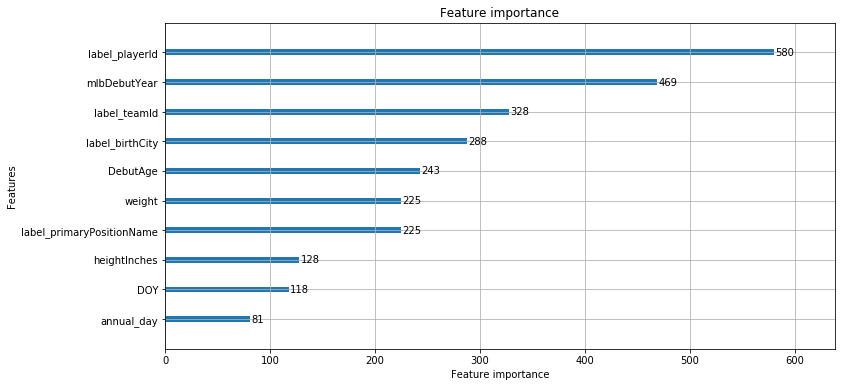

In [23]:
lgbm.plot_importance(model3, figsize=(12, 6), max_num_features=10)

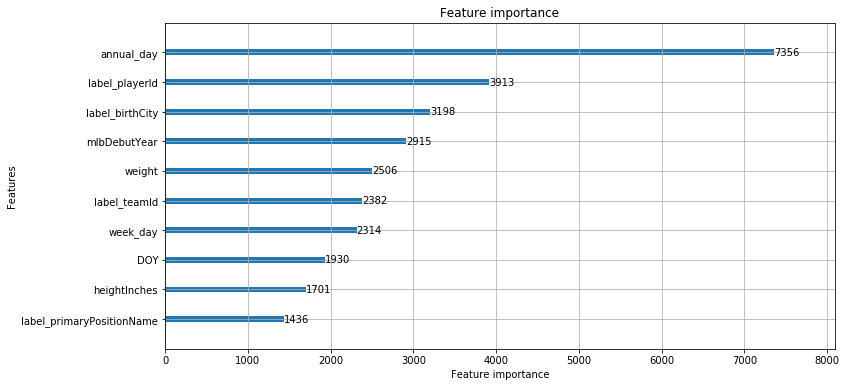

In [24]:
lgbm.plot_importance(model4, figsize=(12, 6), max_num_features=10)

## テストで取ってこれる一行はこんな感じ

In [31]:
example_sample_submission = pd.read_csv(MAIN_DATA_DIR / "example_sample_submission.csv")
example_test = pd.read_csv(MAIN_DATA_DIR / "example_test.csv")
test_df = example_test.set_index('date').iloc[:1]
sample_prediction_df = example_sample_submission[example_sample_submission['date']==test_df.index[0]].set_index('date')

In [52]:
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

# env = mlb.make_env() # initialize the environment
# iter_test = env.iter_test() # iterator which loops over each date in test set

# for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
sample_prediction_df = sample_prediction_df.reset_index(drop=True)

# creat dataset
sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                    .map(lambda x: int(x.split('_')[1]))
# Dealing with missing values
if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
    test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
else:
    test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in rosters.columns:
        if col == 'playerId': continue
        test_rosters[col] = np.nan

if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
    test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
else:
    test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in scores.columns:
        if col == 'playerId': continue
        test_scores[col] = np.nan
test_scores = test_scores.groupby('playerId').sum().reset_index()
test = sample_prediction_df[['playerId']].copy()
test = test.merge(players[players_cols], on='playerId', how='left')
test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
test = test.merge(test_scores[scores_cols], on='playerId', how='left')

test['label_playerId'] = test['playerId'].map(player2num)
test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
test['label_teamId'] = test['teamId'].map(teamid2num)
test['label_status'] = test['status'].map(status2num)
test['label_birthCity'] = test['birthCity'].map(birthCityn2num)

date_ = pd.to_datetime(test_df.index[0], format="%Y%m%d")
test['annual_day'] = (date_ - pd.to_datetime(date_.year, format="%Y")) /  timedelta(days=1)
test['week_day'] = date_.weekday()
test['month'] = date_.month


test_X = test

In [54]:
# predict
pred1 = model1.predict(test_X[feature_cols1])
pred2 = model2.predict(test_X[feature_cols2])
pred3 = model3.predict(test_X[feature_cols3])
pred4 = model4.predict(test_X[feature_cols4])

# merge submission
sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
sample_prediction_df = sample_prediction_df.fillna(0.)

del sample_prediction_df['playerId']

In [55]:
sample_prediction_df

,date_playerId,target1,target2,target3,target4
0,20210427_656669,4.523566,7.302453,2.559227e-01,2.723813
1,20210427_543475,0.147992,3.124557,2.008687e-01,1.193542
2,20210427_592866,0.006262,1.240768,1.289277e-02,1.045266
3,20210427_452678,0.028216,3.628774,4.949686e-02,1.776316
4,20210427_570257,0.008472,1.085709,1.132856e-02,0.437531
...,...,...,...,...,...
1182,20210427_593590,0.000010,0.013661,1.073450e-18,0.000000
1183,20210427_642180,0.002000,1.000161,3.896596e-03,0.397934
1184,20210427_663399,0.000242,0.336076,1.736459e-03,0.087545
1185,20210427_664199,0.000847,0.919104,5.898664e-03,0.507688
